#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

# Outline

<a name="outline"></a>

- [Section 1](#section-1): Data pre-processing
- [Section 2](#section-2): Principal Components Analysis (PCA)
- [Section 3](#section-3): Non-Negative Matrix Factorisation (NMF)

# Linear dimensionality reduction


The purpose of this notebook is to understand and implement two linear dimensionality reduction methods:

1.   Principle Component Analysis (PCA)
2.   Non-Negative Matrix Factorisation (NMF)


The main idea of these methods is to approximate our data by a linear combination of a few components, which span the space for a low-dimensional representation of the data. Such representation is often useful to visualise and inspect the structure of the data in an easier way, allowing us to better understand their properties. Here we illustrate the application of PCA and NMF to a dataset of hand-written digits (MNIST).

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import linalg

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<a name="section-1"></a>
# Section 1: Data pre-processing ([index](#outline))

Let's first load the data. We will use the MNIST dataset which we obtained from `sklearn.datasets.fetch_openml`, but which you can load from the `mnist_data.csv` file. Similarly, the labels for the images can be found in `mnist_labels.csv`.

In [21]:
## EDIT HERE
PATH = 'data/'
labels = pd.read_csv(PATH + 'mnist_labels.csv').to_numpy()
images = pd.read_csv(PATH + 'mnist_data.csv').to_numpy()
print(labels.shape)
print(images.shape)

(5000, 1)
(5000, 784)


We plot one of the images, to do this we need to reshape the data.

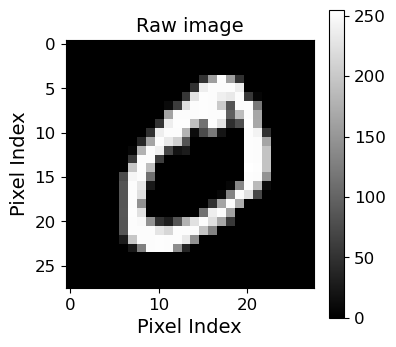

In [22]:
# Plotting the second image
plt.figure(figsize=(4,4))
plt.xlabel('Pixel Index', size=14)
plt.ylabel('Pixel Index', size=14)
plt.title('Raw image', size=14)
plt.imshow(images[1].reshape(28,28), cmap='gray')
plt.colorbar();

Let's now pre-process the data.

In [23]:
print(images.shape)
print(images.max())
print(images.min())

(5000, 784)
255
0


We need to standardise the data. The steps below ensure that the pixels will have zero mean and unitary variance across images. As some pixels are the same for all images (e.g. the corners), we need to be careful to avoid diving my zero.

In [24]:
def standardise(X):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.

    Returns:
        X_std (np.array): Standardised feature matrix
    """

    mu = np.mean(X, axis=0, keepdims=True)
    sigma = np.std(X, axis=0, keepdims=True)
    sigma[sigma == 0] = 1 # to avoid division by zero
    X_std = (X - mu) / sigma

    return X_std

For PCA, we will only consider the first 500 images.

In [25]:
X_std = standardise(images[:500, :])

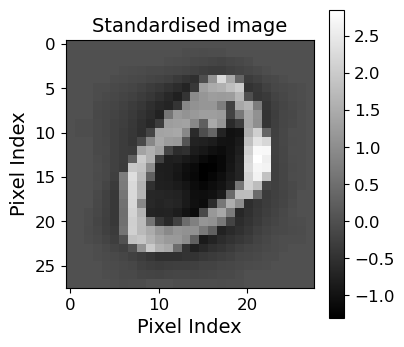

In [26]:
# Plotting the second image (now standardised)
plt.figure(figsize=(4,4))
plt.xlabel('Pixel Index', size=14)
plt.ylabel('Pixel Index', size=14)
plt.title('Standardised image', size=14)
plt.imshow(X_std[1].reshape(28,28), cmap='gray')
plt.colorbar();

We now verify that a given pixel across all the images has zero mean and unitary standard deviation.

In [27]:
rng = np.random.default_rng(0)
random_pixel = rng.integers(0, 784)
np.testing.assert_allclose(np.std(X_std[:, random_pixel]), 1)
# Note that assert_allclose considers relative difference (which involves division)
# we can't assert closeness to 0, so we need to add a small constant to both sides
np.testing.assert_allclose(np.mean(X_std[:, random_pixel] + 0.00001), 0.00001)

<a name="section-2"></a>
# Section 2: Principal Components Analysis (PCA) ([index](#outline))
To perform PCA on
a dataset $\mathbf{X}$ for $m$ principal components,
we need to perform the following steps:

1. Compute the covariance matrix,  $\mathbf C$.
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C$.
3.  Sort the eigenvalues and their corresponding eigenvectors in order of descending magnitude (of the eignenvalues).
4.  Compute the projection onto the spaced spanned by the first $m$ eigenvectors.


We now define the functions `covariance_matrix` and `pca_function` to implement PCA.

In [ ]:
## EDIT HERE
def covariance_matrix(X):
    """
    Parameters:
      X (np.ndarray): Samples matrix, shape (N, p).

    Returns:
     The covariance matrix, shape (p, p).

    """
    return (X-np.mean(X, axis=0)).T @ (X-np.mean(X, axis=0)) / (X.shape[0])


def pca_function(X, m):
    """
    Parameters:
      X (np.ndarray): Samples matrix, shape (N, p).
      m (int): Number of principal components (m<=p).

    Returns:
      X_pca (np.ndarray): Projected data, shape (N, m).
      eigenvectors (np.ndarray): First m eigenvectors of C, shape (p, m).
      eigenvalues (np.ndarray): First m eigenvalues of C, shape (m, ).

    """
    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigendecomposition using the np.linalg.eigh function
    eigen = np.linalg.eigh(C)

    eigenvalues = eigen[0][-m:][::-1]
    threshold = 1e-10
    eigenvalues[np.abs(eigenvalues) < threshold] = 0

    eigenvectors = eigen[1][:, -m:][:, ::-1]

    X_pca = (X - np.mean(X, axis=0, keepdims=True)) @ eigenvectors

    return X_pca, eigenvectors, eigenvalues

Test the PCA function for three principal components ($m=3$).

In [33]:
m = 3 # the number of principal components
X_pca, eigenvectors, eigenvalues = pca_function(X_std, m)

np.testing.assert_allclose(eigenvalues, np.array([45.281472, 30.465387, 27.128733]))

(784, 784)


Now consider a larger number such as $m=100$. Plot the spectrum, *i.e.*, the histogram of the eigenvalues of $\mathbf{C}$ with the `density` parameter set to `True`.

(784, 784)


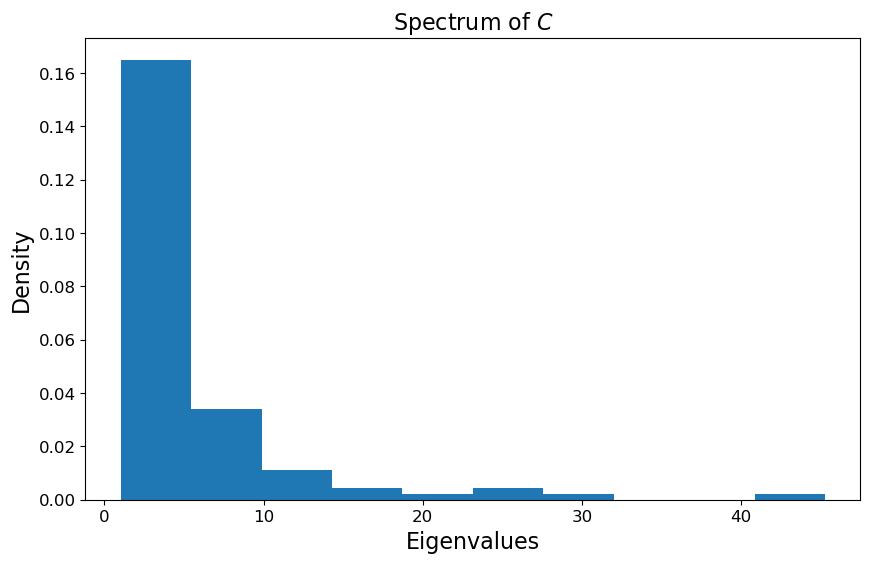

In [34]:
m = 100
X_pca, eigenvectors, eigenvalues = pca_function(X_std, m)
plt.figure(figsize=(10,6))
plt.hist(eigenvalues, density=True)
plt.xlabel('Eigenvalues')
plt.ylabel('Density')
plt.title('Spectrum of $C$')
plt.show()

If we look at the spectrum, the presence of large values indicates there are directions with large variance *i.e.* signal is present in the data.

If we **randomly permute** the pixels of each image, which is equivalent to 'randomising' the data, the signal, and therefore, the large eigenvalues disappear. Reshuffle every column separately, using `rng` below (not `np.random`) to remove correlations between pixels.

In [ ]:
# EDIT HERE
X_std_random = np.copy(X_std)
n, p = X_std.shape

# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION

And now we plot the spectrum of the randomised data:

In [ ]:
X_std_random = standardise(X_std_random)
X_pca_random, eigenvectors_random, eigenvalues_random = pca_function(X_std_random, m)

plt.figure(figsize=(10,6))
plt.hist(eigenvalues_random, density=True);
plt.xlabel('Eigenvalues')
plt.ylabel('Density')
plt.title('Spectrum of $C_{rand}$')
plt.show()

**Question:** what can you say about the previous plot? Compare it with the case in which the columns were not randomly permuted ($m=100$).

Let's go back to the original case with $m=100$ and analyse what fraction of the overall variance is explained by the components. Edit this cell to calculate the total variance of $X$ (as the sum of the absolute values of the eigenvalues). Plot the explained proportion of variance for the first $100$ principal components. Your code should pass the included test.

In [ ]:
# EDIT HERE
C = covariance_matrix(X_std)
all_eigenvalues, _ = # <-- EDIT THIS LINE
total_variance =  # <-- EDIT THIS LINE

explained_variances = # <-- EDIT THIS LINE

plt.figure(figsize=(10,6))
plt.plot(np.arange(100), explained_variances)
plt.axhline(y = 1, color = 'r', linestyle = '-', label='Full variance')
plt.axhline(y = 0.8, color = 'k', linestyle = '--', label='80% of variance')
plt.xlabel('Eigenvalue index')
plt.ylabel('Proportion of explained variance')
plt.legend()
plt.show()

np.testing.assert_allclose(explained_variances[64], 0.8033379096824053)

Complete the cell below to find the number of components that allows us to **explain at least 80%** of the total variance.

In [ ]:
# EDIT HERE
opt_k = # <-- EDIT THIS LINE
print(opt_k)

Let's now try and understand what these different principle components represent for a given image. Plot the first 20 eigenvectors as images.

In [ ]:
# EDIT HERE
# <-- SOLUTION
# <-- SOLUTION

# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION

Using `opt_k` principal components, approximate the 6th image (setting `index_image` equal to `5`).

In [ ]:
# EDIT HERE
index_image = 5

# represent each image as a linear combination of principal components
approximate_image = # <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(X_std[index_image].reshape([28,28]))
ax[0].set_title('Original Image')
ax[0].set_xlabel('Pixel Index')
ax[0].set_ylabel('Pixel Index')
ax[1].imshow(approximate_image.reshape([28,28]))
ax[1].set_xlabel('Pixel Index')
ax[1].set_ylabel('Pixel Index')
ax[1].set_title('Approximated Image');

We see that the general shape of the two is present, including those points that are brightest on the original image (the end of the two).

**Exercise:** compute the approximated images using the $m$ components that account for $70%$ and $90\%$ of the total variance. What is the difference?

From the original `images` array consisting of $5000$ images, create an array of the images of the digits 5 and 7 only.



In [ ]:
# EDIT HERE
ind_5 = # <-- EDIT THIS LINE
ind_7 =  # <-- EDIT THIS LINE
X_5 = # <-- EDIT THIS LINE
X_7 =  # <-- EDIT THIS LINE
X_subset = # <-- EDIT THIS LINE
n_5 = len(ind_5)
n_7 = len(ind_7)
n_datapoints = n_5 + n_7
X_subset_std = standardise(X_subset)

Now we find the first two principal components of this new dataset and plot the data points in a 2D space based on their projections onto eigenvectors 1 and 2 (`PC1` and `PC2`).

In [ ]:
m = 2
X_subset_pca, eigenvectors, eigenvalues = pca_function(X_subset_std, m)

plt.figure(figsize=(10,10))
plt.scatter(X_subset_pca[:n_5, 0], X_subset_pca[:n_5, 1], label='Digit 5')
plt.scatter(X_subset_pca[n_5:n_datapoints, 0],
            X_subset_pca[n_5:n_datapoints, 1], label='Digit 7')
plt.legend()
plt.xlabel('Projection onto PC1')
plt.ylabel('Projection onto PC2')
plt.title('Digits 5 and 7')
plt.show()

**Exercise:**
1. Define a function that calculates the error between the original and the approximated image. A standard choice is the Mean Squared Error (MSE).
2. Calculate the MSE for all images.
3. Plot the average MSE as a function of $m$. Can we use this plot to decide `opt_m`?

<a name="section-3"></a>
# Section 3: Non-negative matrix factorisation (NMF) ([index](#outline))

Now we will look at non-negative matrix factorisation. NMF is a matrix factorisation method where we constrain the matrices to have non-negative elements (while PCA produces components with elements that could be both positive and negative).

NMF factors our $N\times p$ data matrix $\mathbf X$ into matrices with nonnegative elements $\mathbf W$ ($N\times r$) and $\mathbf H$ ($r\times p$), i.e. $\mathbf X \approx \mathbf W\mathbf H$. $\mathbf W\mathbf H$ is lower-rank ($r < p$), hence it gives a low-dimensional approximation of $\mathbf X$.

Note that for non-negative matrix factorisation we require the input matrix to be non-negative. However we still want to implement some form of standarisation so that features on different scales don't dominate the cost function. Therefore, we normalise each feature to fall between 0 and 1.

In [ ]:
## EDIT HERE
# glabally normalise to 0-1
def normalize_nmf(X):
    """
    Globally normalise features.

    Parameters:
        X (np.array): Feature matrix.

    Returns:
        X_norm (np.array): Normalised feature matrix
    """
    X_norm = ## <-- EDIT THIS LINE
    return X_norm

We will consider, and normalise, the first $1000$ images.

In [ ]:
n_datapoints = 1000
X_norm = normalize_nmf(images[:n_datapoints] / 255.)
X_norm.shape

As explained in the lecture notes, we find $\mathbf{W}$ and $\mathbf{H}$ as the local minima of cost functions that represent the quality of the approximation of $\mathbf{X}$ by $\mathbf{WH}$. We will see the implementation of the optimisation of the two main cost functions used for NMF.

## Cost function: Euclidean distance

The first is the square of the Euclidean distance between the data $\mathbf{X}$ and the product $\mathbf{WH}$:

<center>
$
||\mathbf{X} - \mathbf{WH}||^2 = \sum_{ij}(X_{i,j} - (\mathbf{WH})_{ij})^2
$
</center>

Local minima of this function are found by the Lee and Seung's multiplicative update rules:
<center>
$
W_{ij}^{t+1}\leftarrow W_{ij}^{t}
\frac{(\mathbf{X}(\mathbf{H}^{t})^T)_{ij}}{(\mathbf{W}^t \mathbf{H}^{t} (\mathbf{H}^{t})^T)_{ij}}
$
</center>

and

<center>
$
H_{jk}^{t+1}\leftarrow H_{jk}^{t}
\frac{(( \mathbf{W}^{t+1})^T \mathbf{X})_{jk}}{((\mathbf{W}^{t+1})^T \mathbf{W}^{t+1} \mathbf{H}^t)_{jk}}
$
</center>


which are repeated for several iterations $n$ until $\mathbf{W}$ and $\mathbf{H}$ converge. It is important to note that updates are done on an element by element basis and not by  matrix multiplication. In practice, a small positive scalar is added to the denominators in the above expression in order to avoid division by zero.

Edit the function below to calculate the cost for a given factorisation.


In [ ]:
## EDIT HERE
def euclidean_cost(X, W, H):
    """
    Computes the Euclidean NMF cost function.

    Parameters:
      X (np.ndarray): Data matrix, shape (N, p).
      W (np.ndarray): Weight matrix, shape (N, r).
      H (np.ndarray): Feature matrix, shape (r, p).

    Returns:
      cost_value (float): Value of the cost function.
    """

    # Check that W and H can be multiplied together
    assert W.shape[1] == H.shape[0], "The inner dimensions of W and H do not match for multiplication."

    # Test to see whether the size of X and the size of W times H matches
    assert X.shape == (W.shape[0], H.shape[1]), "The dimensions of X do not match the dimensions of WH."

    # compute the difference between X and the matrix product of W and H
    diff = ## <-- EDIT THIS LINE

    # Compute the Euclidean distance-based cost function
    cost_value = ## <-- EDIT THIS LINE

    return cost_value

Now we will implement Lee and Seung's multiplicative update rule. This algorithm works by iteratively, updating matrix $\mathbf{W}$ and then matrix $\mathbf{H}$ until convergence.

As with all iterative schemes, initial values for $\mathbf{W}$ and $\mathbf{H}$ are needed. Whilst many procedures exist to obtain efficient initial values that aim to (i) improve convergence time and (ii) reduce final cost value, we will simply take random matrices as initial matrices $\mathbf{W}$ and $\mathbf{H}$.


In [ ]:
# EDIT THIS FUNCTION
def euclidean_NMF(X, r, rng, epsilon=0.0001, n_iters=500):
  """
  Implements NMF with the euclidean cost function.

  Parameters:
    X (np.ndarray): Data matrix, shape (N, p).
    r (int): Number of components.
    rng (np.random.default_rng): Random number generator.
    epsilon (float): Small positive scalar, default 0.0001.
    n_iters (int): Number of iterations, default 500.

  Returns:
    W (np.ndarray): Weight matrix, shape (N, r).
    H (np.ndarray): Feature matrix, shape (r, p).
    cost_values (list): List of cost values for each iteration.
  """
  # N x r components matrix, usually interpreted as the weights of each feature
  W = rng.random((X.shape[0], r))
  # r x P matrix interpreted as the basis set
  H = rng.random((r, X.shape[1]))

  # empty list
  cost_values = []

  # loop over the n iterations
  for _ in range(n_iters):
      # compute the update on W
      W =  ## <-- EDIT THIS LINE
      # compute the update on H
      H =  ## <-- EDIT THIS LINE
      # compute the cost and append to list
      cost_values.append(euclidean_cost(X, W, H))

  return W, H, cost_values

In [ ]:
rng = np.random.default_rng(0)
r = 2
W, H, cost_values = euclidean_NMF(X_norm, r, rng)

In [ ]:
np.testing.assert_allclose(cost_values[-1], 44724.21957)

We should verify that we have converged to a solution by plotting the value of our cost function over the iterations.

In [ ]:
# plotting the cost, to check convergence
plt.figure(figsize=(10,6))
plt.plot(cost_values)
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence')
plt.show()

We see that the algorithm has converged.

We now have a look at the columns of $\mathbf{W}$ and the rows of $\mathbf{H}$. Each column $\mathbf{W}_{[:, j]}$ contains information about the relationship between the samples and feature $j$. Therefore we colour point $(W_{i, 0},W_{i, 1})$ by the digit label of sample $i$, to give an indication of the information relating to digit label contained in features $0$ and $1$. As $\mathbf{H}$ contains information about the $p$ features rather than the samples, we can't similarly colour these points.

In [ ]:
labs = labels[:1000].reshape(-1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(10):
    axs[0].scatter(W[labs == i, 0], W[labs == i, 1],  label=i)
axs[0].set_xlabel('$W_{:, 0}$')
axs[0].set_ylabel('$W_{:, 1}$')
axs[0].set_title('Columns of W')
axs[0].legend()
axs[1].scatter(H[0, :], H[1, :])
axs[1].set_xlabel('$H_{0, :}$')
axs[1].set_ylabel('$H_{1, :}$')
axs[1].set_title('Rows of H')
plt.show()

And plot the histograms for the first column of $\mathbf{W}$ and first row of $\mathbf{H}$.

In [ ]:
labs = labels[:1000]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(W[:,0], bins = 40)
axs[0].set_xlabel('$W_{:, 0}$')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of $W_{:, 0}$')
axs[1].hist(H[0, :], bins = 40)
axs[1].set_xlabel('$H_{0, :}$')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of $H_{0, :}$')
plt.show()

We can observe that:

*   these matrices have non-negative entries as we expected
*   they are sparse (which is a desirable property!)
*   the columns of $W$ seem to contain some information about the cluster the image belongs to.





## Cost function: Divergence

Next, we repeat the optimisation monitoring the trend of a different cost function, the divergence $D$ defined as:
<center>
$
D(\mathbf{X}||\mathbf{WH}) = \sum_{ij}\left[X_{ij} \log\left(\frac{X_{ij}}{(\mathbf{WH})_{ij}}\right) - X_{ij} +(\mathbf{WH})_{ij}\right]
$
</center>

for which we are guaranteed to find local minima by slightly different multiplicative update rules:

<center>
$
W_{ij}^{t+1}\leftarrow W_{ij}^{t}
\frac{\sum_k H_{jk}^tX_{ik} / (\mathbf{W}^t\mathbf{H}^{t})_{ik} }{\sum_k H^{t}_{jk}}
$
</center>

and

<center>
$
H_{jk}^{t+1}\leftarrow H_{jk}^{t}
\frac{ \sum_i W^{t+1}_{ij}X_{ik} / (\mathbf{W}^{t+1}\mathbf{H}^t)_{ik}}{\sum_i W^{t+1}_{ij}}
$
</center>

We first define the cost function `divergence_cost` before writing a function to implement NMF with this particular cost function, `divergence_NMF`.

In [ ]:
## EDIT HERE
def divergence_cost(X, W, H, epsilon=0.0001):
    """
    Computes the divergence NMF cost function.

    Parameters:
      X (np.ndarray): Data matrix, shape (N, p).
      W (np.ndarray): Weight matrix, shape (N, r).
      H (np.ndarray): Feature matrix, shape (r, p).

    Returns:
      cost_value (float): Value of the cost function.
    """

    # Check that W and H can be multiplied together
    assert W.shape[1] == H.shape[0], "The inner dimensions of W and H do not match for multiplication."

    # Test to see whether the size of X and the size of W times H matches
    assert X.shape == (W.shape[0], H.shape[1]), "The dimensions of X do not match the dimensions of WH."

    # compute the divergence term by term
    ## we add a small epsilon to avoid ill-defined divisions/log
    term = ## <-- EDIT THIS LINE

    # sum over the terms
    cost_value = ## <-- EDIT THIS LINE
    return cost_value

In [ ]:
# EDIT THIS FUNCTION
def divergence_NMF(X, r, rng, epsilon=0.0001, n_iters=500):
  """
  Implements NMF with the divergence cost function.

  Parameters:
    X (np.ndarray): Data matrix, shape (N, p).
    r (int): Number of components.
    rng (np.random.default_rng): Random number generator.
    epsilon (float): Small positive scalar, default 0.0001.
    n_iters (int): Number of iterations, default 500.

  Returns:
    W (np.ndarray): Weight matrix, shape (N, r).
    H (np.ndarray): Feature matrix, shape (r, p).
    cost_values (list): List of cost values for each iteration.
  """
  # N x r components matrix, usually interpreted as the weights of each feature
  W = rng.random((X.shape[0], r))
  # r x P matrix interpreted as the basis set
  H = rng.random((r, X.shape[1]))

  # empty list
  cost_values = []

  # loop over the n iterations
  for _ in range(n_iters):

      # compute the update on W
      W = ## <-- EDIT THIS LINE
      # compute the update on H
      H = ## <-- EDIT THIS LINE
      # compute the cost and append to list
      cost_values.append(divergence_cost(X, W, H))

  return W, H, cost_values

We implement NMF with $r=2$.

In [ ]:
r = 2
rng = np.random.default_rng(0)
W, H, cost_values = divergence_NMF(X_norm, r, rng)

It should pass the following test:

In [ ]:
np.testing.assert_allclose(cost_values[-1], 85293.31274)

Again, we check convergence has occured:

In [ ]:
# plotting the cost, to check convergence
plt.figure(figsize=(10,6))
plt.plot(cost_values)
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence')
plt.show()

Note as this is a different cost function to that used previously, the final values at convergence for the two algorithms are not something we can compare.

We now produce the same plots for NMF with the divergence cost function as for the Euclidean cost funciton.

In [ ]:
labs = labels[:1000].reshape(-1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(10):
    axs[0].scatter(W[labs == i, 0], W[labs == i, 1],  label=i)
axs[0].set_xlabel('$W_{:, 0}$')
axs[0].set_ylabel('$W_{:, 1}$')
axs[0].set_title('Columns of W')
axs[0].legend()
axs[1].scatter(H[0, :], H[1, :])
axs[1].set_xlabel('$H_{0, :}$')
axs[1].set_ylabel('$H_{1, :}$')
axs[1].set_title('Rows of H')
plt.show()

In [ ]:
labs = labels[:1000]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(W[:,0], bins = 40)
axs[0].set_xlabel('$W_{:, 0}$')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of $W_{:, 0}$')
axs[1].hist(H[0, :], bins = 40)
axs[1].set_xlabel('$H_{0, :}$')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of $H_{0, :}$')
plt.show()

And we see similar trends *i.e.* non-negativity and sparseness.

Finally, we can have a look at the difference components resulting from our NMF and see what information they might contain. Edit the following cell so that it produces two plots side by side, of the first and second rows of $H$ plotted as images.

In [ ]:
# EDIT THIS CODE
# <-- SOLUTION
# <-- SOLUTION

# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION

We now implement NMF with another value of r.

In [ ]:
# choosing the number of dimensions (r) on which to project
r = 10
rng = np.random.default_rng(0)
W, H, cost_values = euclidean_NMF(X_norm, r, rng)

It should pass the following test:

In [ ]:
np.testing.assert_allclose(cost_values[-1], 29502.85551)

Again, we would like to see what the different components represent. Edit the following cell so that it produces two rows of 5 plots, with one image for each rows of $H$.

In [ ]:
# EDIT THIS CODE
# <-- SOLUTION
# <-- SOLUTION

# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION
# <-- SOLUTION

**Exercises:**



*   Implement this with sklearn and check that the method has been correctly implemented.
    *   We expect this to be slightly different, the sklearn implementation relies on the optimisation of a slightly different cost function:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
*   Check that the result of NMF is the same if you
use another version of cost function, the one from the paper:
https://www.nature.com/articles/44565.





